In [10]:
# read in images.txt from dir

import os
import sys
import re
import pandas as pd
import geopandas as gpd

path = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'Res_640', 'PittsburghDowntown_2024-03-20', 'images.txt' )

# read into df
df = pd.read_csv(path, sep=' ', header=None)

# rename columns 
cols = ['segment_id', 'filename', 'image_panoid', 'date', 'query_counter', 'lat', 'lon', 'end']
df.columns = cols
# drop "end"
df.drop('end', axis=1, inplace=True)

# convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Convert to geopandas with lat/lon as point coordinates geometry
pics_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

pics_gdf['years_since_today'] = (pd.Timestamp('2024-03-20') - pics_gdf['date']) 

# transform days to roughly equal years that have passed
pics_gdf['years_since_today'] = round( pics_gdf['years_since_today'].dt.days/365 , 2)

# Create subset of not saved
not_saved = pics_gdf[pics_gdf['filename'] == 'NotSaved']

# filter to only include filename != NotSaved
pics_gdf = pics_gdf[pics_gdf['filename'] != 'NotSaved']

print(f"Number of images: {len(pics_gdf)}")
print(f"Number of images not saved: {len(not_saved)}")

pics_gdf


Number of images: 9043
Number of images not saved: 18828


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72
4,104197837-271197326,img_104197837-271197326_h0_002.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,4.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72
5,104197837-271197326,img_104197837-271197326_h1_003.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,5.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72
10,104197837-271197326,img_104197837-271197326_h0_004.png,RxyMGiyoWym7PsB6LXBG6A,2022-07-01,10.0,40.447093,-80.007474,POINT (-80.00747 40.44709),1.72
...,...,...,...,...,...,...,...,...,...
27848,105116527-10970185374,img_105116527-10970185374_h1_001.png,zetqk7qEuvpT82BgGoVgRw,2023-05-01,9.0,40.437957,-80.004160,POINT (-80.00416 40.43796),0.89
27851,105116527-10970185374,img_105116527-10970185374_h0_002.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,12.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47
27852,105116527-10970185374,img_105116527-10970185374_h1_003.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,13.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47
27867,105116527-10970185374,img_105116527-10970185374_h0_004.png,WxPeiIxfXMlduvcaRHFCtQ,2023-10-01,28.0,40.437737,-80.003904,POINT (-80.00390 40.43774),0.47


In [11]:
# read in segments json file to get segment_id to segment_name mapping
path = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'segment_dictionary_PittsburghDowntown.json' )
segments = pd.read_json(path, orient='index')

# segment_id is a string formatted as a list. Modify it to remove brackets, comma and cocatentate with hypen
segments['segment_id'] = segments['segment_id'].apply(lambda x: x.replace('[','').replace(']', '').replace(', ','-'))

# Merge name, length and bearing to pics_gdf
pics_gdf = pics_gdf.merge(segments[['segment_id', 'name', 'length', 'bearing']], on='segment_id')

pics_gdf

,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,name,length,bearing
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72,Mazeroski Way,118.831,166.7
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (-80.00754 40.44730),1.72,Mazeroski Way,118.831,166.7
2,104197837-271197326,img_104197837-271197326_h0_002.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,4.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72,Mazeroski Way,118.831,166.7
3,104197837-271197326,img_104197837-271197326_h1_003.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,5.0,40.447208,-80.007510,POINT (-80.00751 40.44721),1.72,Mazeroski Way,118.831,166.7
4,104197837-271197326,img_104197837-271197326_h0_004.png,RxyMGiyoWym7PsB6LXBG6A,2022-07-01,10.0,40.447093,-80.007474,POINT (-80.00747 40.44709),1.72,Mazeroski Way,118.831,166.7
...,...,...,...,...,...,...,...,...,...,...,...,...
9038,105116527-10970185374,img_105116527-10970185374_h1_001.png,zetqk7qEuvpT82BgGoVgRw,2023-05-01,9.0,40.437957,-80.004160,POINT (-80.00416 40.43796),0.89,Market Street,63.434,207.0
9039,105116527-10970185374,img_105116527-10970185374_h0_002.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,12.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47,Market Street,63.434,207.0
9040,105116527-10970185374,img_105116527-10970185374_h1_003.png,86NWZiQxDKwRr4gDGKld8A,2023-10-01,13.0,40.437913,-80.004374,POINT (-80.00437 40.43791),0.47,Market Street,63.434,207.0
9041,105116527-10970185374,img_105116527-10970185374_h0_004.png,WxPeiIxfXMlduvcaRHFCtQ,2023-10-01,28.0,40.437737,-80.003904,POINT (-80.00390 40.43774),0.47,Market Street,63.434,207.0


In [12]:
import matplotlib.pyplot as plt
import json

# Define the directories containing the shapefiles

neighbord_gdf = gpd.read_file('pittsburgh_gis_data/Neighborhoods_/Neighborhoods_.shp')
parks_gdf = gpd.read_file('pittsburgh_gis_data/PGHWebParks/PGHWebParks.shp')
roads_gdf = gpd.read_file('pittsburgh_gis_data/tl_2020_42003_roads/tl_2020_42003_roads.shp')
water_gdf = gpd.read_file('pittsburgh_gis_data/majrivrs/majrivrs.shp')

# read in json of downtown 
with open('./pittsburgh_gis_data/downtown_polygon.json', 'r') as file:
    downtown_polygon = json.load(file)
downtown_gdf = gpd.GeoDataFrame.from_features(downtown_polygon['features'])


# read in downtown_surrounds_polygon.json and clip 4 gdfs to area
with open('./pittsburgh_gis_data/downtown_surroundings_polygon.json', 'r') as file:
    downtown_surrounds_polygon = json.load(file)

# Clip neighborhood, parks, roads, and water to downtown_surrounds_polygon
downtown_surrounds_gdf = gpd.GeoDataFrame.from_features(downtown_surrounds_polygon['features'])
neighbord_gdf = gpd.clip(neighbord_gdf, downtown_surrounds_gdf)
parks_gdf = gpd.clip(parks_gdf, downtown_surrounds_gdf)
roads_gdf = gpd.clip(roads_gdf, downtown_surrounds_gdf)
water_gdf = gpd.clip(water_gdf, downtown_surrounds_gdf)





/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/320133265.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  neighbord_gdf = gpd.clip(neighbord_gdf, downtown_surrounds_gdf)
/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/320133265.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  parks_gdf = gpd.clip(parks_gdf, downtown_surrounds_gdf)
/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/320133265.py:25: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPS

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/382690620.py:6: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_gdf.plot(ax=ax, color='blue', alpha=0.5)


(40.434, 40.448)

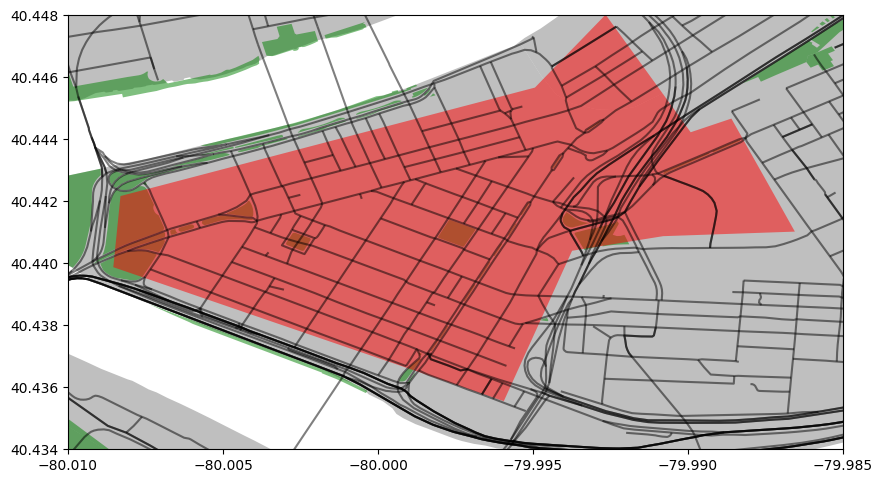

In [13]:
#plot 5 shapefiles, zooming to downtown_gdf
fig, ax = plt.subplots(figsize=(10,10))
neighbord_gdf.plot(ax=ax, color='grey', alpha=0.5)
parks_gdf.plot(ax=ax, color='green', alpha=0.5)
roads_gdf.plot(ax=ax, color='black', alpha=0.5)
water_gdf.plot(ax=ax, color='blue', alpha=0.5)
downtown_gdf.plot(ax=ax, color='red', alpha=0.5)

# zoom
ax.set_xlim(-80.01, -79.985)
ax.set_ylim(40.434, 40.448)


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/3467963864.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_gdf.plot(ax=ax, color='blue', alpha=0.9)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


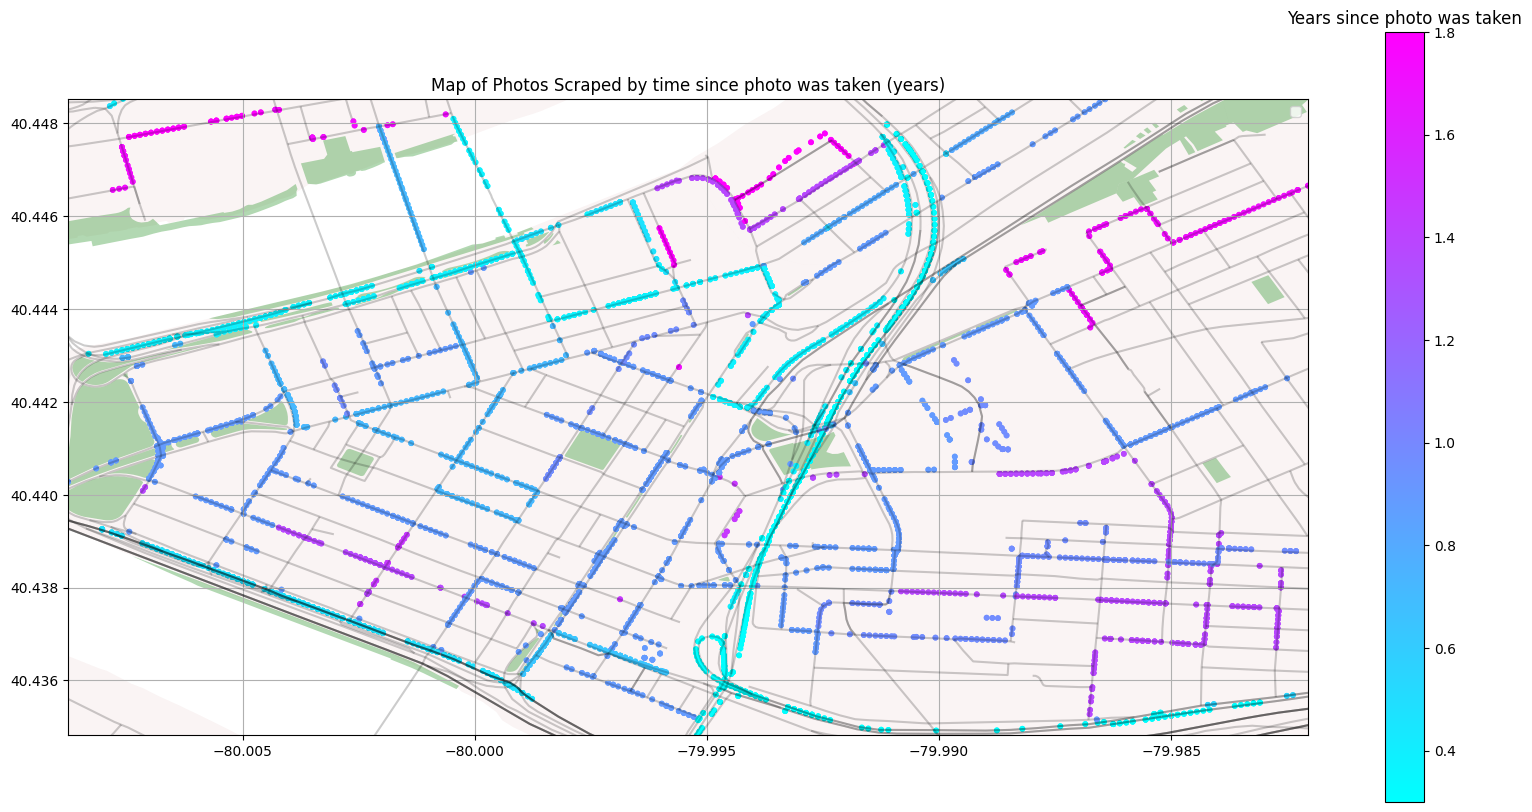

/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/3467963864.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_gdf.plot(ax=ax, color='blue', alpha=0.9)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


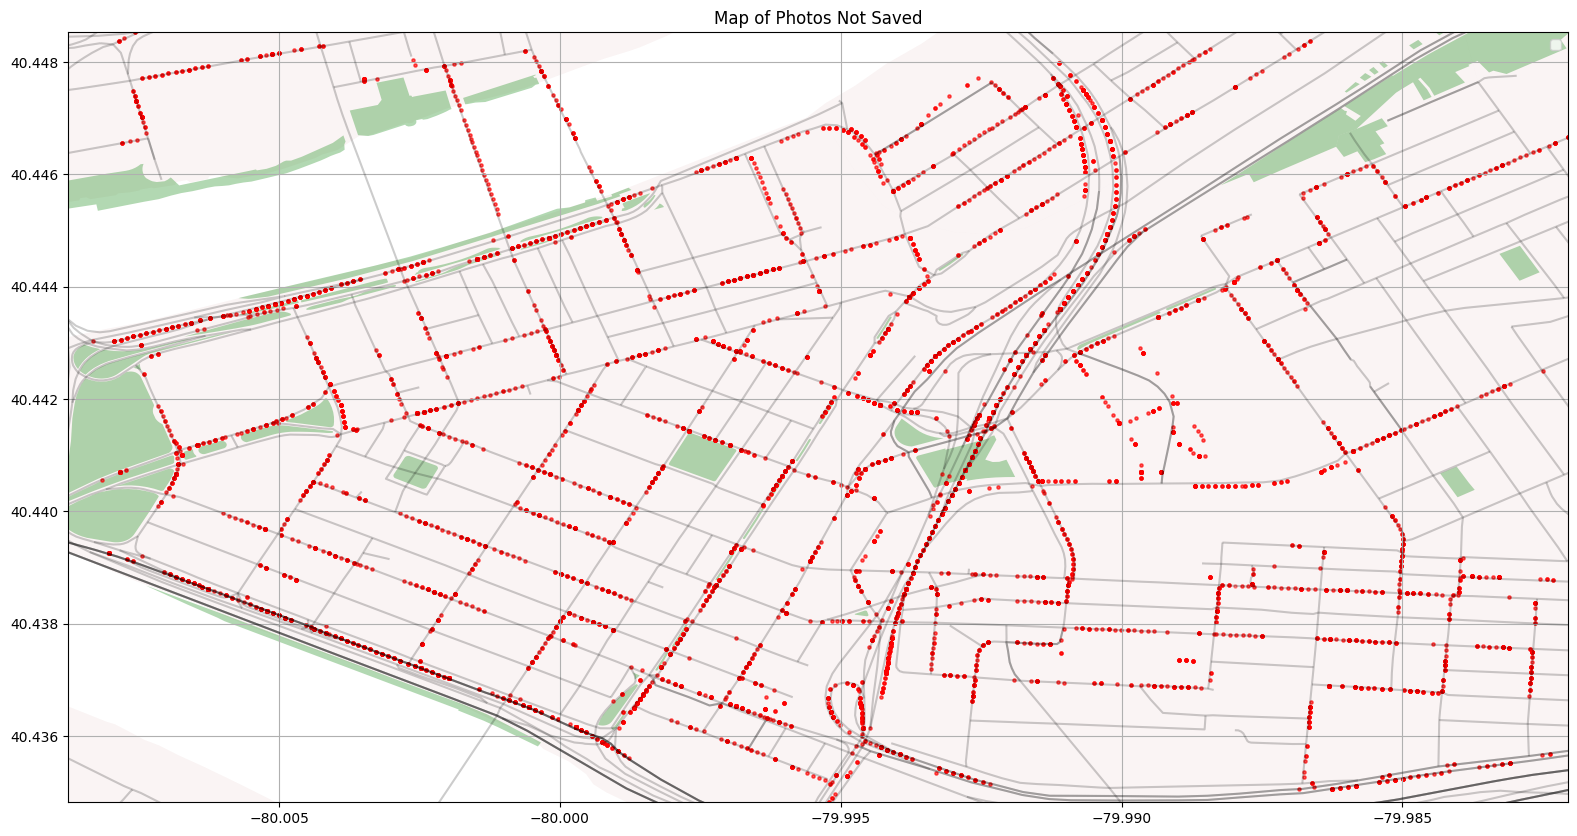

In [14]:

for gdf, title in zip( [pics_gdf, not_saved], ['Map of Photos Scraped by time since photo was taken (years)', 'Map of Photos Not Saved']):


    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the shapefiles
    neighbord_gdf.plot(ax=ax, color='brown', alpha=0.05)
    parks_gdf.plot(ax=ax, color='green', alpha=0.3)
    roads_gdf.plot(ax=ax, color='black', alpha=0.2, linewidth=1.5)
    water_gdf.plot(ax=ax, color='blue', alpha=0.9)

    if title == 'Map of Photos Scraped by time since photo was taken (years)':
        # Plot the points with color equaling the year of the "date" column
        pics_gdf.plot(ax=ax, column='years_since_today', cmap='cool', legend=True, markersize=10)

    elif title == 'Map of Photos Not Saved':
        # plot not saved with red box
        not_saved.plot(ax=ax, color='red', alpha=0.4, markersize=5)

    # Zoom to the extent of the points in 'pics_gdf'
    minx, miny, maxx, maxy = pics_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add grid, legend, and title
    ax.set_title(title)
    ax.grid(True)
    plt.legend(loc='upper right')

    # add legend title
    if title == 'Map of Photos Scraped by time since photo was taken (years)':
        cax = fig.get_axes()[1]
        cax.set_title('Years since photo was taken')




    # Show the plot
    plt.show()


In [15]:
# count number of points from photos gdf that are in downtown polygon
downtown_pics_gdf = gpd.clip(pics_gdf, downtown_gdf)
downtown_pics_gdf = downtown_pics_gdf.dropna(subset=['geometry'])
print(f"Number of photos in downtown: {len(downtown_pics_gdf)}")



Number of photos in downtown: 4242


In [16]:
# how many pics have NA name?
print(f"Number of photos with NA name: {len(downtown_pics_gdf[downtown_pics_gdf['name'].isna()])}")

# change nan to "NA" string
downtown_pics_gdf['name'].fillna('NA', inplace=True)

# for any list in "name" column, convert to string
downtown_pics_gdf['name'] = downtown_pics_gdf['name'].apply(lambda x: x if type(x) != list else ', '.join(x) )

Number of photos with NA name: 577


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/508452767.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  downtown_pics_gdf['name'].fillna('NA', inplace=True)


In [17]:
# in downtown pics, remove pics corresponding to certain street names, ignoring case
street_names = ['Crosstown Boulevard', "Veteran's Bridge", "Boulevard of the Allies"]
street_names = street_names + ['Bigelow Boulevard', 'Bedford Avenue']

for name in street_names:
    # how many pics to remove? print
    print(f"Number of photos with {name}: { downtown_pics_gdf['name'].str.contains(name, case=False).sum()}")
    downtown_pics_gdf = downtown_pics_gdf[~downtown_pics_gdf['name'].str.contains(name, case=False)]

Number of photos with Crosstown Boulevard: 118
Number of photos with Veteran's Bridge: 0
Number of photos with Boulevard of the Allies: 204
Number of photos with Bigelow Boulevard: 144
Number of photos with Bedford Avenue: 88


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_4916/645958717.py:8: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  water_gdf.plot(ax=ax, color='blue', alpha=0.9)


(40.434, 40.448)

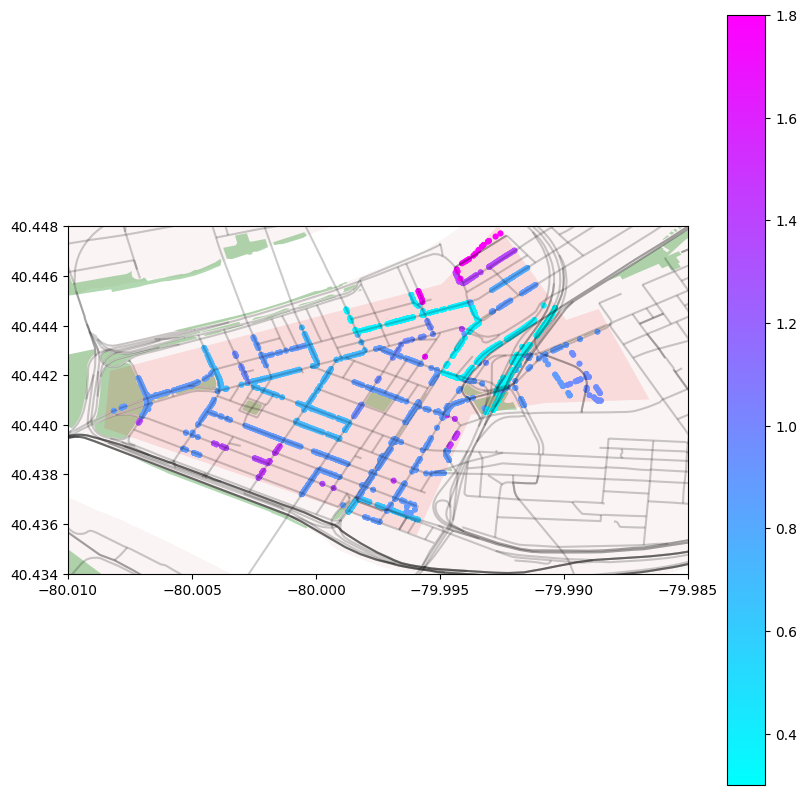

In [18]:
# plot the downtown photos along with baselayers
fig, ax = plt.subplots(figsize=(10,10))

# Plot the shapefiles
neighbord_gdf.plot(ax=ax, color='brown', alpha=0.05)
parks_gdf.plot(ax=ax, color='green', alpha=0.3)
roads_gdf.plot(ax=ax, color='black', alpha=0.2, linewidth=1.5)
water_gdf.plot(ax=ax, color='blue', alpha=0.9)
downtown_gdf.plot(ax=ax, color='red', alpha=0.1)

# Plot the points with color equaling the year of the "date" column
downtown_pics_gdf.plot(ax=ax, column='years_since_today', cmap='cool', legend=True, markersize=10)

# zoom  
ax.set_xlim(-80.01, -79.985)
ax.set_ylim(40.434, 40.448)


In [19]:
new_dir = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'Res_640', 'in_downtown')

# for each filename in downtown_pics_gdf, copy the file to new_dir
for filename in downtown_pics_gdf['filename']:
    old_path = os.path.join(  '../Data', 'ProcessedData', 'SFStreetView', 'Res_640', 'PittsburghDowntown_2024-03-20', filename)
    new_path = os.path.join(new_dir, filename)
    #os.system(f'cp {old_path} {new_path}')

In [22]:
downtown_pics_gdf

# save df 
downtown_pics_gdf.to_csv('./downtown_pics_df.csv', index=False)